# 존체계 간 교통량을 나타내는 라인 생성

In [1]:
%matplotlib inline
import warnings
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
from tabulate import tabulate
from shapely.ops import unary_union
# import folium

plt.rcParams['figure.figsize'] = (13,13)
plt.rcParams['font.family'] = 'Malgun Gothic'

warnings.filterwarnings("ignore")

In [2]:
# OD 존체계_shp 불러오기
zone = './데이터/OD_교통량/6. 존체계_shp/제주_존체계.shp'
zone_stru = gpd.read_file(zone, encoding ='euc-kr')
zone_stru.geometry = zone_stru.geometry.set_crs('EPSG:5179')
zone_stru.head()

,BASE_DATE,ADM_CD,ADM_NM,시도,시군구,행정동코드,존번호,geometry
0,20220630,39010110,한림읍,제주특별자치도,제주시,5.011025e+09,1,"MULTIPOLYGON (((880342.194 1487994.148, 880341..."
1,20220630,39010120,애월읍,제주특별자치도,제주시,5.011025e+09,2,"MULTIPOLYGON (((888236.112 1495784.484, 888238..."
2,20220630,39010130,구좌읍,제주특별자치도,제주시,5.011026e+09,3,"MULTIPOLYGON (((946603.199 1499746.050, 946601..."
3,20220630,39010140,조천읍,제주특별자치도,제주시,5.011026e+09,4,"MULTIPOLYGON (((918857.288 1505399.837, 918857..."
4,20220630,39010310,한경면,제주특별자치도,제주시,5.011031e+09,5,"MULTIPOLYGON (((875956.099 1477617.079, 875955..."


In [3]:
# 서귀포 동 결합
seogui_lst = ['송산동', '정방동', '중앙동', '천지동',
       '효돈동', '영천동', '동홍동', '서홍동', '대륜동', '대천동', '중문동', '예래동']

seogui_geo = [row['geometry'] for idx, row in zone_stru.iterrows() if row.ADM_NM in seogui_lst]
mergePolys = gpd.GeoSeries(zone_stru[zone_stru.ADM_NM.isin(seogui_lst)].unary_union) # 서귀포동 좌표 추출

zone_stru = zone_stru[zone_stru.ADM_NM.isin(seogui_lst)==False]
# zone_stru.drop(['BASE_DATE', 'ADM_CD','시도', '시군구', '행정동코드'], axis =1, inplace = True)
seogui_series = gpd.GeoDataFrame({'ADM_NM':'서귀포동', '존번호':32, 'geometry':mergePolys})

zone_stru = pd.concat([zone_stru, seogui_series], axis = 0)

In [4]:
# OD_존체계_중심 불러오기
zone_cen = pd.concat([zone_stru.loc[:,['ADM_NM','존번호']], zone_stru.centroid], axis = 1)
zone_cen.columns = ['ADM_NM', '존번호', 'geometry']
zone_cen = gpd.GeoDataFrame(zone_cen, geometry = 'geometry')
zone_cen.geometry = zone_cen.geometry.set_crs('EPSG:5179')
zone_cen.head()

,ADM_NM,존번호,geometry
0,한림읍,1,POINT (886921.085 1487890.636)
1,애월읍,2,POINT (897141.530 1491610.862)
2,구좌읍,3,POINT (934585.728 1500944.263)
3,조천읍,4,POINT (922641.466 1498141.739)
4,한경면,5,POINT (881111.890 1481957.685)


In [5]:
# OD 교통량 예측치 불러오기
od_30 = pd.read_csv('./데이터/OD_교통량/4. OD/제주권 주수단OD 30년.csv')
od_35 = pd.read_csv('./데이터/OD_교통량/4. OD/제주권 주수단OD 35년.csv')

In [6]:
def replace_wrongstr(df, cols, string):
    for col in cols:
        for idx, row in df.iterrows():
            if string in str(df.loc[idx,col]):
                df.loc[idx,col] = df.loc[idx,col].replace(string,'')
        df[col] = df[col].astype('float')
    return df

cols_to_replace = ['도보/자전거', '승용차', '버스', '철도', '택시', '기타', '승용차/택시', '기타합계', '총합']
od_30 = replace_wrongstr(od_30, cols_to_replace ,',')
od_35 = replace_wrongstr(od_35, cols_to_replace ,',')

def to_astype(df, cols, dtype):
    for col in cols:
        df[col] = df[col].astype(dtype)
    return df

od_30 = to_astype(od_30, ['도보/자전거', '승용차', '택시', '기타', '승용차/택시', '기타합계', '총합'], 'float')
od_35 = to_astype(od_35, ['도보/자전거', '승용차', '택시', '기타', '승용차/택시', '기타합계', '총합'], 'float')

In [7]:
def to_seogui(df): # 데이터 전처리
    zone_num = [i for i in range(32,44)] # 결합된 서귀포동의 행정동 번호 리스트
    zone_start = [i for i in range(1,32)] # 서귀포동을 제외한 존번호 리스트
    df1 = df[(df.출발.isin(zone_start))&(df.도착.isin(zone_num))].groupby(['출발']).sum().reset_index()
    df1.도착 = 32
    
    seogui_od = df[(df.출발.isin(zone_num))&(df.도착.isin(zone_num))].groupby(['출발']).sum().reset_index()
    seogui_od.도착 = 32
    
    seogui_od = seogui_od.groupby('도착').sum().reset_index()
    seogui_od.columns = ['출발', '도착', '도보/자전거', '승용차', '버스', '철도', '택시', '기타', '승용차/택시', '기타합계',
           '총합', '6.70%', '1.30%']
    seogui_od.도착 = 32

    od = df[(df.출발.isin(zone_num)==False)&(df.도착.isin(zone_num) == False)]
    
    df2 = df[(df.출발.isin(zone_num))&(df.도착.isin(zone_start))].groupby(['출발','도착']).sum().reset_index()
    df2 = df2.groupby('도착').sum().reset_index()
    df2 = df2.iloc[:,[1,0,2,3,4,5,6,7,8,9,10,11,12]]
    df2.출발 = 32
    
    rest_od = pd.concat([od, df1, seogui_od, df2], axis = 0)
    rest_od = rest_od.sort_values(by = ['출발','도착'], ascending = True)
    return rest_od

od_30 = to_seogui(od_30)
od_35 = to_seogui(od_35)

In [8]:
# OD_존체계와 OD 교통량 예측치 결합

def merge_df_gdf(gdf, df, gdf_col, df_col):
    gdf = pd.DataFrame(gdf)
    merge_df = pd.merge(gdf, df, how = 'outer', left_on = gdf_col, right_on = df_col)
    return gpd.GeoDataFrame(merge_df)

merge_zone_30 = merge_df_gdf(zone_cen, od_30, '존번호', '출발')
merge_zone_35 = merge_df_gdf(zone_cen, od_35, '존번호', '출발')

In [9]:
# 존번호의 좌표값 할당한 딕셔너리 생성
def col_to_dict(df, col, col2):
    dit = dict()
    for i in range(len(df)):
        dit.setdefault(df.iloc[i][col], df.iloc[i][col2])
    return dit

dit = col_to_dict(zone_cen, '존번호','geometry')

# 도착한 동의 좌표값 할당
def to_geometry(gdf, col, new_col):
    lst = [dit[gdf[col].loc[i]] for i in range(len(gdf)) if gdf[col].loc[i] in dit.keys()]
    gdf[new_col] = lst
    return gdf

merge_zone_30 = to_geometry(merge_zone_30,'도착', 'geometry_arrive')
merge_zone_35 = to_geometry(merge_zone_35,'도착', 'geometry_arrive')

In [10]:
# 라인 생성
def create_line_between_points(point1, point2):
    line = LineString([point1, point2])
    return line

# 지오데이터프레임의 두 변수를 기준으로 선을 만들어 추가하는 함수
def add_lines_between_points(geo_df, point1_variable, point2_variable):
    result_gdf = geo_df.copy()
    result_gdf['line'] = result_gdf.apply(lambda row: create_line_between_points(row[point1_variable], row[point2_variable]), axis=1)
    
    return result_gdf

result_gdf_30 = add_lines_between_points(merge_zone_30, 'geometry', 'geometry_arrive')
result_gdf_35 = add_lines_between_points(merge_zone_35, 'geometry', 'geometry_arrive')

In [11]:
result_gdf_30 = gpd.GeoDataFrame(result_gdf_30, geometry = 'line')
result_gdf_35 = gpd.GeoDataFrame(result_gdf_35, geometry = 'line')

<Axes: >

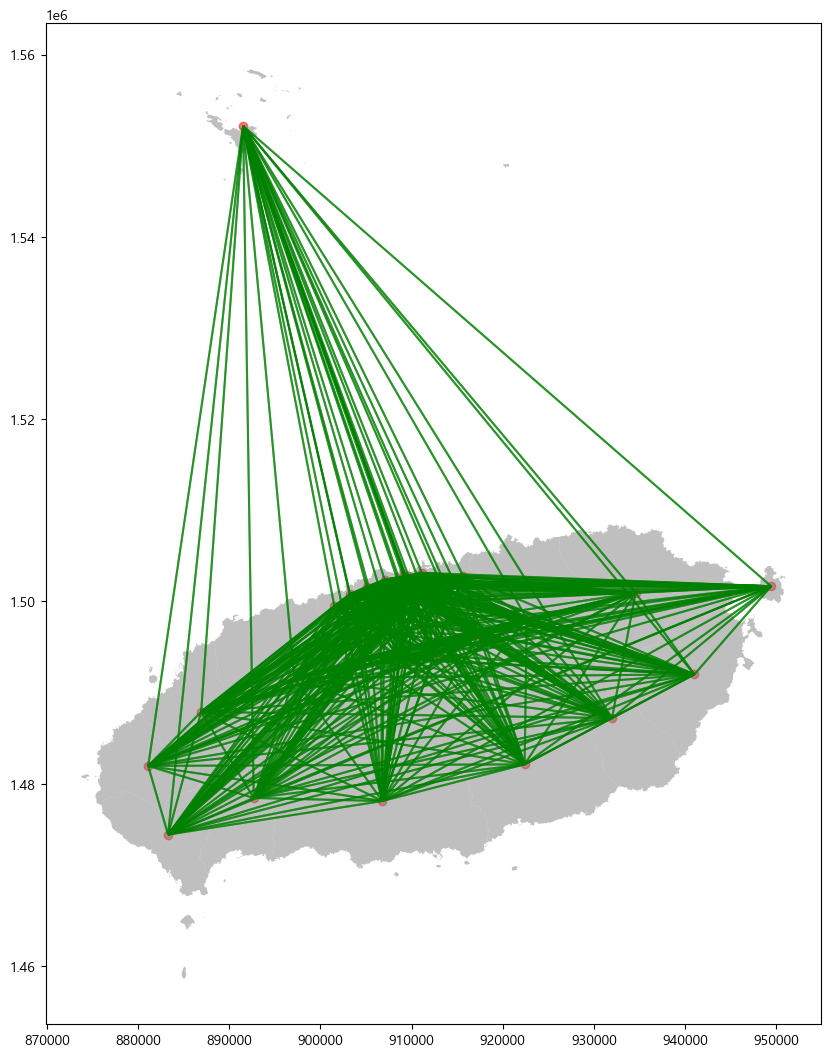

In [12]:
fig, ax = plt.subplots()

zone_cen.plot(ax = ax, color = 'red', alpha = 0.5)
result_gdf_30.plot(ax = ax, color = 'green', alpha = 0.6)
zone_stru.plot(ax = ax, color = 'grey', alpha = 0.5)

In [13]:
result_gdf_30.drop(['geometry', 'geometry_arrive'], axis=1, inplace =True)
result_gdf_35.drop(['geometry', 'geometry_arrive'], axis=1, inplace =True)

In [14]:
result_gdf_30.rename(columns = {'존번호':'zone_num',
                             '출발':'start','도착':'arrive', '도보/자전거':'walk/bicycle', '승용차':'car', 
                             '버스':'bus', '철도':'train', '택시':'taxi', '기타':'rest', 
                             '승용차/택시':'car/taxi', '기타합계':'rest_sum', '총합':'total'},inplace = True)
result_gdf_35.rename(columns = {'존번호':'zone_num',
                             '출발':'start','도착':'arrive', '도보/자전거':'walk/bicycle', '승용차':'car', 
                             '버스':'bus', '철도':'train', '택시':'taxi', '기타':'rest', 
                             '승용차/택시':'car/taxi', '기타합계':'rest_sum', '총합':'total'},inplace = True)

In [15]:
result_gdf_30.set_geometry(col='line', inplace =True)
result_gdf_35.set_geometry(col='line', inplace =True)

# .shp 내보내기
# result_gdf_30.to_file('./데이터/OD_교통량/6. 존체계_shp/존_교통량_30년.shp', encoding = 'cp949')
# result_gdf_35.to_file('./데이터/OD_교통량/6. 존체계_shp/존_교통량_35년.shp', encoding = 'cp949')

## 데이터 전처리

- 결측치는 존재하지 않음
- 우도면과 용담이동 사이 버스 교통량이 존재하여 우도면은 분석에서 제외할 것
- 추자면은 자기 자신 포함 모든 동과의 교통량이 존재하지 않아 분석에서 제외할 것

In [16]:
od_30_gdf = result_gdf_30.copy()
od_35_gdf = result_gdf_35.copy()

def replace_wrongstr(df, cols, string):
    for col in cols:
        for idx, row in df.iterrows():
            if string in str(df.loc[idx,col]):
                df.loc[idx,col] = df.loc[idx,col].replace(string,'')
        df[col] = df[col].astype('float')
    return df

cols_to_replace = ['walk/bicycle', 'car', 'bus', 'train', 'taxi', 'rest', 'car/taxi', 'rest_sum', 'total']
od_30_gdf = replace_wrongstr(od_30_gdf, cols_to_replace ,',')
od_35_gdf = replace_wrongstr(od_35_gdf, cols_to_replace ,',')

# 데이터 타입 변환
cols = ['zone_num', 'start', 'arrive']
od_30_gdf = to_astype(od_30_gdf, cols, 'object')
od_35_gdf = to_astype(od_35_gdf, cols, 'object')

In [17]:
# # 추자면, 우도면 제외
# def no_traffic(df, zone_name):
#     df = df.query('ADM_NM != "zone_name"')
#     return df

# od_30_gdf = no_traffic(od_30_gdf, "우도면")
# od_30_gdf = no_traffic(od_30_gdf, "추자면")
# od_35_gdf = no_traffic(od_35_gdf, "우도면")
# od_35_gdf = no_traffic(od_35_gdf, "추자면")

In [18]:
# 시작-도착 행정동 매칭
def match_dong(df, col):
    hang = col_to_dict(zone_cen, '존번호', 'ADM_NM')
    lst = [v for i in range(len(hang)) for k,v in hang.items()]
    df[col] = lst
    return df

od_30_gdf = match_dong(od_30_gdf, 'arrive_zone')
od_35_gdf = match_dong(od_35_gdf, 'arrive_zone')

In [19]:
drop_columns = ['zone_num', 'start', 'arrive', 'walk/bicycle', 'car', 'train',
       'taxi', 'rest', 'rest_sum', 'total', '6.70%', '1.30%']
od_30_gdf = od_30_gdf.drop(drop_columns, axis =1)
od_35_gdf = od_35_gdf.drop(drop_columns, axis =1)

In [20]:
od_30_gdf.columns

Index(['ADM_NM', 'bus', 'car/taxi', 'line', 'arrive_zone'], dtype='object')

In [21]:
# 승용차/택시 + 버스 = 총 교통량 변수 생성
od_30_gdf['total'] = od_30_gdf['bus'] + od_30_gdf['car/taxi']
od_35_gdf['total'] = od_35_gdf['bus'] + od_35_gdf['car/taxi']

In [37]:
# 상위 10개의 교통량을 가진 데이터프레임 출력
def top_traffic_polygon(df, col):
    lst = zone_cen.ADM_NM.unique()
    dict_ = dict.fromkeys(lst, 0)
    
    df = df.loc[df.ADM_NM != df.arrive_zone,] # 자신 제외
    for v in lst:
        df2 = df[df.arrive_zone==v].sort_values(by = col, ascending = False).iloc[:13][[col,'ADM_NM']]
        traffic_name = '{0} 교통량'.format(col)
        df2.rename(columns = {col:traffic_name, 'ADM_NM': '출발동'}, inplace = True)
        for k, v in dict_.items():
            if k in df2['출발동'].tolist():
                dict_[k] += 1
    return pd.Series(dict(sorted(dict_.items(), key = lambda x: x[1], reverse = True))).transpose()
#         print('{0} 행정동의 상위 10개 교통량입니다.'.format(v))
#         df2.plot.bar('도착동', traffic_name)
#         plt.title('{0} 행정동에서 다른 행정동으로의 교통량이 많은 상위 10개의 행정동입니다.'.format(v))
#         print(tabulate(df2, headers = 'keys', tablefmt='psql', stralign = 'center'))


In [47]:
# 그룹바이 만들기
def top_traffic_zones(df, col):
    df = df.loc[df.ADM_NM != df.arrive_zone,] # 자신 제외
    df = df[df['ADM_NM'] != df['arrive_zone']].copy()  # 자신 제외
    # 각 도착지에 대해 상위 10개 교통량 합을 가진 도착지 반환
    result = df.groupby(['ADM_NM']).sum(col).sort_values(by = col, ascending = False).iloc[:13][col]
    return result

In [48]:
# 30년 버스 수단 활용하는 존 by 존 상위 10위에 들어간 행정동 횟수
bus_30 = pd.DataFrame(top_traffic_polygon(od_30_gdf, 'bus').reset_index())
bus_30.columns = ['ADM_NM', '30년 버스 교통량']

cartaxi_30 = pd.DataFrame(top_traffic_polygon(od_30_gdf, 'car/taxi').reset_index())
cartaxi_30.columns = ['ADM_NM', '30년 승용차/택시 교통량']

total_30 = pd.DataFrame(top_traffic_polygon(od_30_gdf, 'total').reset_index())
total_30.columns = ['ADM_NM', '30년 총 교통량']

bus_35 = pd.DataFrame(top_traffic_polygon(od_35_gdf, 'bus').reset_index())
bus_35.columns = ['ADM_NM', '35년 버스 교통량']

cartaxi_35 = pd.DataFrame(top_traffic_polygon(od_35_gdf, 'car/taxi').reset_index())
cartaxi_35.columns = ['ADM_NM', '35년 승용차/택시 교통량']

total_35 = pd.DataFrame(top_traffic_polygon(od_35_gdf, 'total').reset_index())
total_35.columns = ['ADM_NM', '35년 총 교통량']

In [49]:
# 30년 버스 수단 활용하는 존 by 존 상위 10위에 들어간 행정동 횟수
bus_30_zones = pd.DataFrame(top_traffic_zones(od_30_gdf, 'bus').reset_index())
bus_30_zones.columns = ['ADM_NM','30년 버스 교통량']

cartaxi_30_zones = pd.DataFrame(top_traffic_zones(od_30_gdf, 'car/taxi').reset_index())
cartaxi_30_zones.columns = ['ADM_NM','30년 승용차/택시 교통량']

total_30_zones = pd.DataFrame(top_traffic_zones(od_30_gdf, 'total').reset_index())
total_30_zones.columns = ['ADM_NM','30년 총 교통량']

bus_35_zones = pd.DataFrame(top_traffic_zones(od_35_gdf, 'bus').reset_index())
bus_35_zones.columns = ['ADM_NM','35년 버스 교통량']

cartaxi_35_zones = pd.DataFrame(top_traffic_zones(od_35_gdf, 'car/taxi').reset_index())
cartaxi_35_zones.columns = ['ADM_NM','35년 승용차/택시 교통량']

total_35_zones = pd.DataFrame(top_traffic_zones(od_35_gdf, 'total').reset_index())
total_35_zones.columns = ['ADM_NM','35년 총 교통량']

In [50]:
total_30.sort_values(by = '30년 총 교통량', ascending = False).iloc[:10]

,ADM_NM,30년 총 교통량
0,용담2동,30
1,연동,28
2,노형동,28
3,아라동,25
4,이도2동,23
5,서귀포동,23
6,애월읍,21
7,조천읍,18
8,이도1동,17
9,화북동,17


In [51]:
total_35.sort_values(by = '35년 총 교통량', ascending = False).iloc[:10]

,ADM_NM,35년 총 교통량
0,용담2동,30
1,연동,28
2,노형동,28
3,아라동,25
4,이도2동,23
5,서귀포동,23
6,애월읍,21
7,조천읍,18
8,이도1동,17
9,화북동,17


In [52]:
total_30_zones

,ADM_NM,30년 총 교통량
0,용담2동,115226.0
1,연동,110508.0
2,노형동,97580.0
3,서귀포동,90661.0
4,아라동,89842.0
5,이도2동,86586.0
6,애월읍,59087.0
7,조천읍,50240.0
8,일도2동,43934.0
9,화북동,42319.0


In [53]:
total_35_zones

,ADM_NM,35년 총 교통량
0,용담2동,115793.0
1,연동,111607.0
2,노형동,98518.0
3,서귀포동,91454.0
4,아라동,90748.0
5,이도2동,87487.0
6,애월읍,59438.0
7,조천읍,50520.0
8,일도2동,43919.0
9,화북동,42367.0


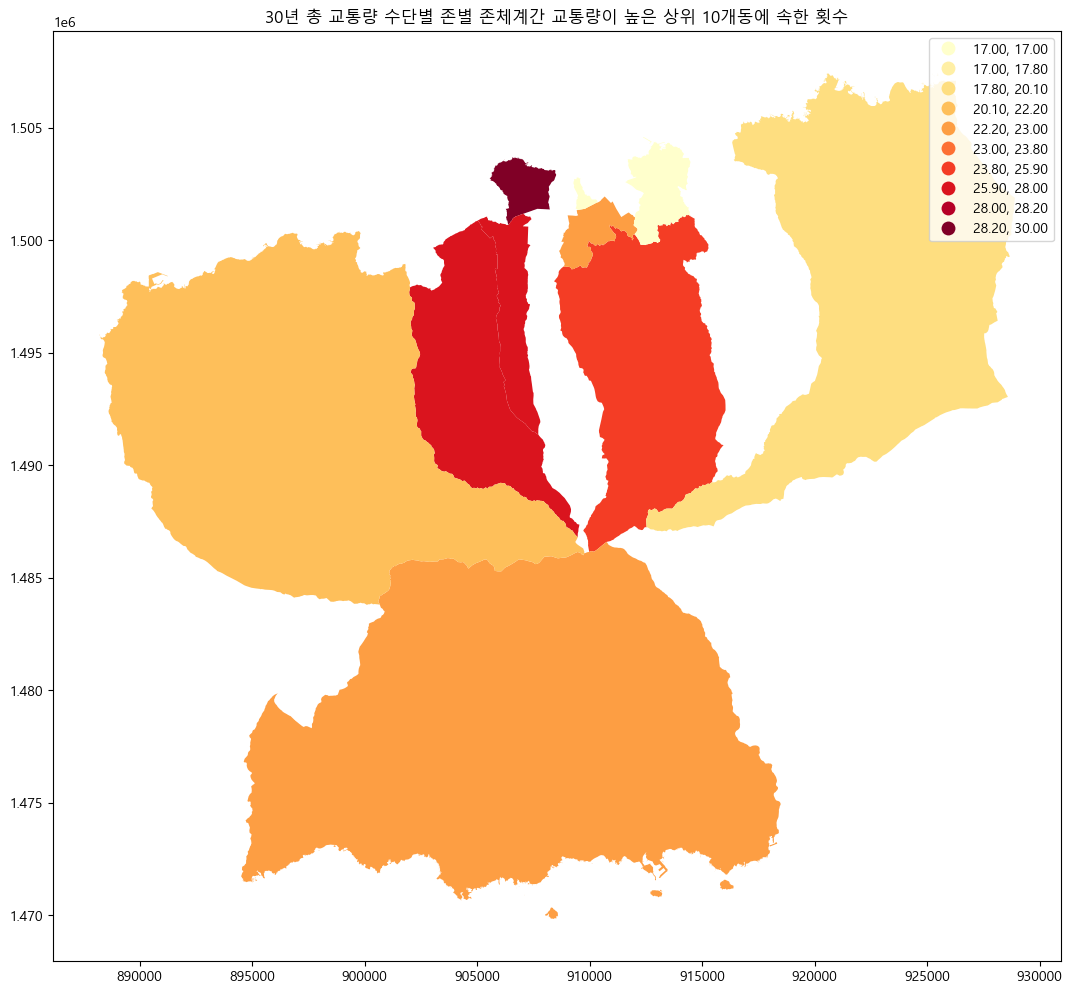

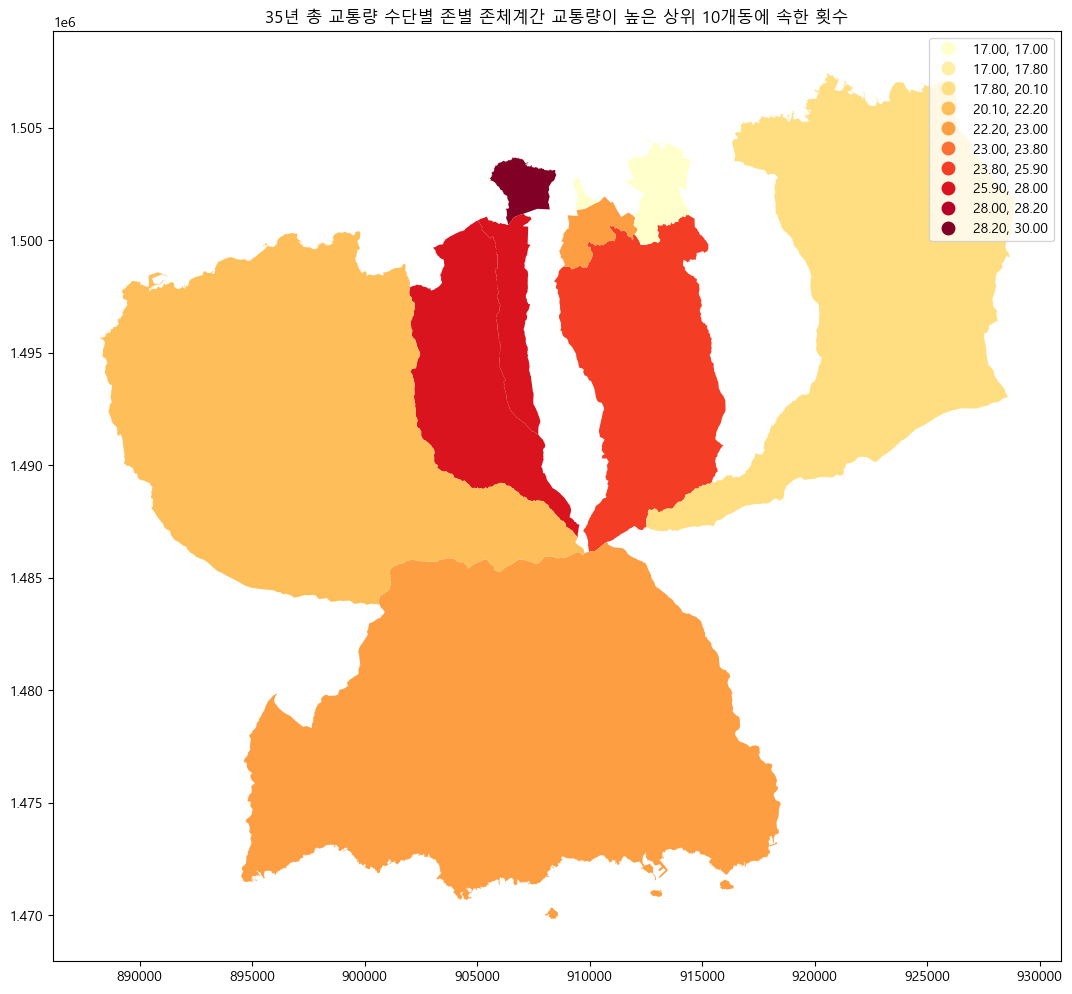

In [54]:
# 데이터 시각화

def graph_(df, col):
    dit = pd.Series(col_to_dict(zone_stru, 'ADM_NM','geometry')).reset_index()
    dit.columns = ['ADM_NM','geometry']
    df2 = gpd.GeoDataFrame(pd.merge(df.iloc[:10], dit, on = 'ADM_NM'))
    df2.plot(column = col, legend = True, scheme = 'quantiles',k= 10, cmap = 'YlOrRd')
    plt.title('{0} 수단별 존별 존체계간 교통량이 높은 상위 10개동에 속한 횟수'.format(col))
graph_(total_30, '30년 총 교통량')
graph_(total_35, '35년 총 교통량')

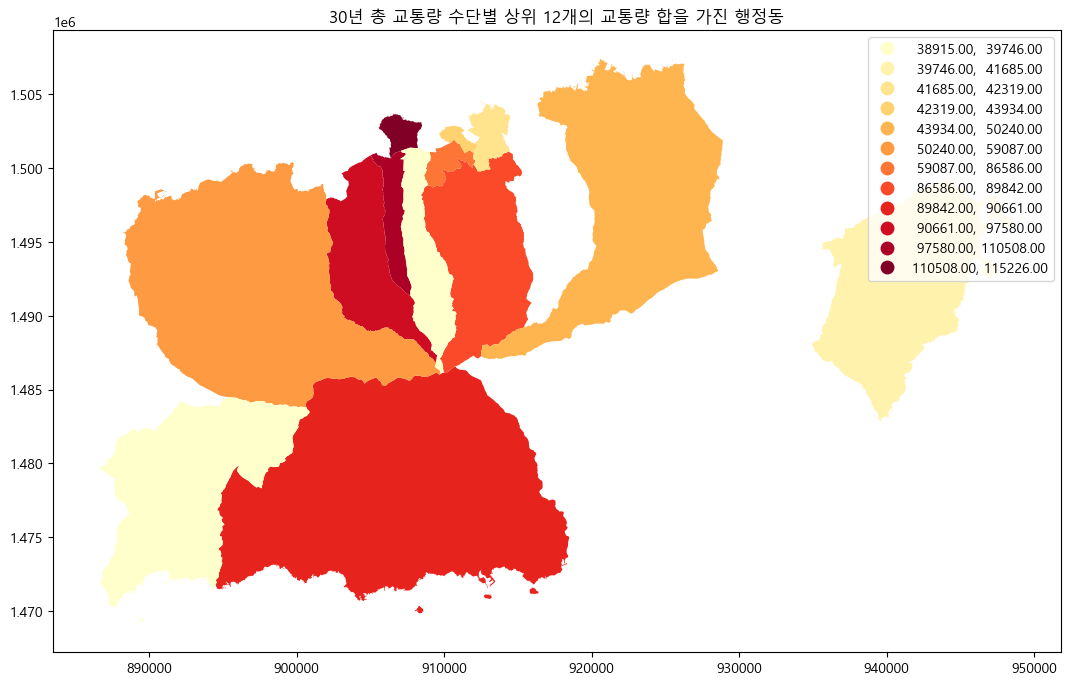

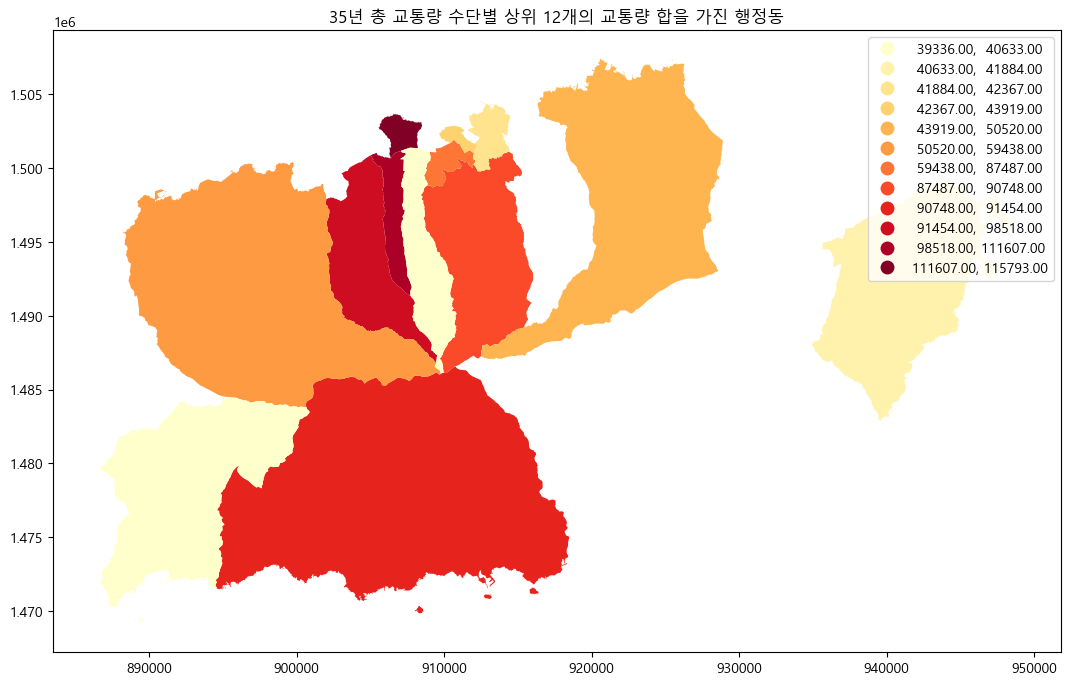

In [56]:
def graph_zones(df, col):
    dit = pd.Series(col_to_dict(zone_stru, 'ADM_NM','geometry')).reset_index()
    dit.columns = ['ADM_NM','geometry']
    df2 = gpd.GeoDataFrame(pd.merge(df, dit, on = 'ADM_NM'))
    df2.plot(column = col, legend = True, scheme = 'quantiles',k= 12, cmap = 'YlOrRd')
    plt.title('{0} 수단별 상위 12개의 교통량 합을 가진 행정동'.format(col))

graph_zones(total_30_zones, '30년 총 교통량')
graph_zones(total_35_zones, '35년 총 교통량')

## 상위 교통량 링크 도출 및 시각화

In [33]:
def top_traffic_link(df, col, year):
    df_ = df.copy()
    df_ = df_.loc[df.ADM_NM != df.arrive_zone,] # 자신 제외
    df_ = df_.sort_values(by = col, ascending = False).iloc[:100,] # 상위 교통량 100순위 링크 도출
    
    df_sorted = df_.sort_values(by = col,ascending = True)
    max_col = df_sorted[col].max()

    lst = [(max_col - float(row[col])) / max_col for idx, row in df_sorted.iterrows()]
    ranks = [sorted(lst, reverse = True).index(i)/5 for i in lst]

    # 시각화
    fig, ax = plt.subplots(figsize = (13,13))
    zone_stru.plot(ax = ax, color = 'grey', alpha = 0.7)
    for i in range(df_sorted.shape[0]):
        df_row = gpd.GeoDataFrame(df_sorted.iloc[i].to_frame().transpose(), geometry = 'line')
        df_row.plot(ax = ax,column = col,color = 'green',
                 linewidth = ranks[i]/3, alpha = 0.5)
    zone_cen.plot(ax = ax, color = 'red')
    plt.title('{0} {1} 수단별 상위 교통량 링크 시각화'.format(year, col))
    return df_

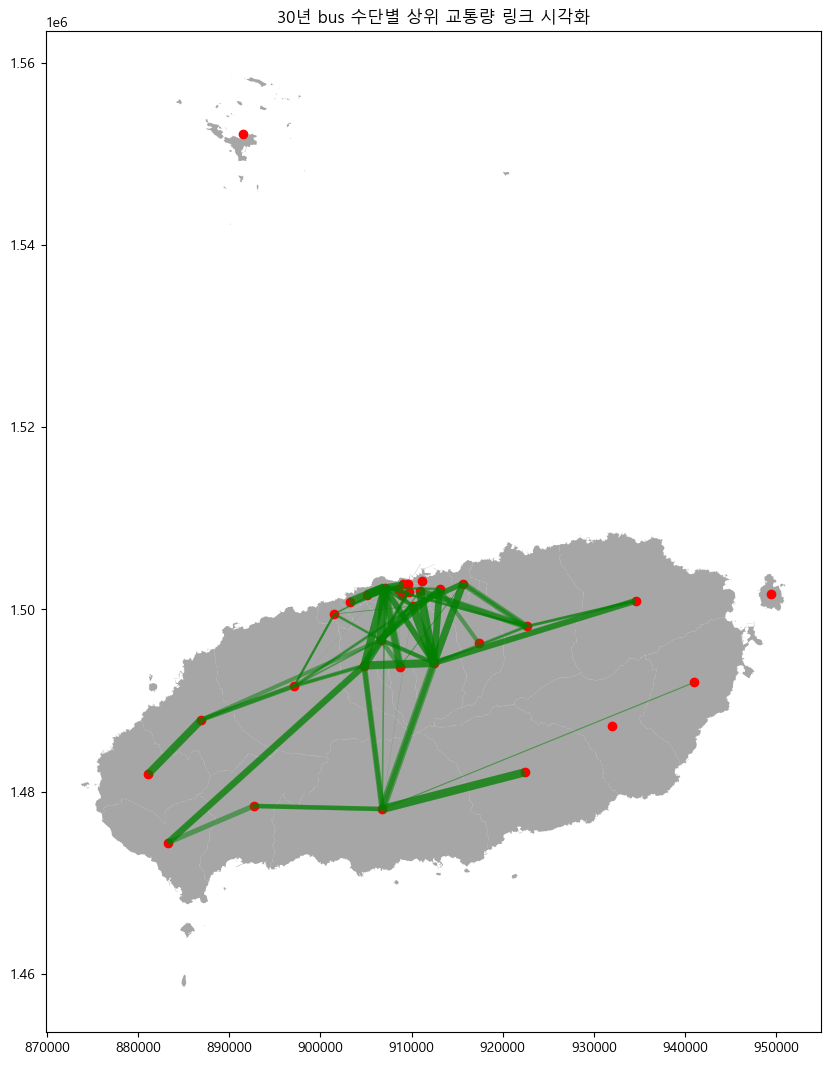

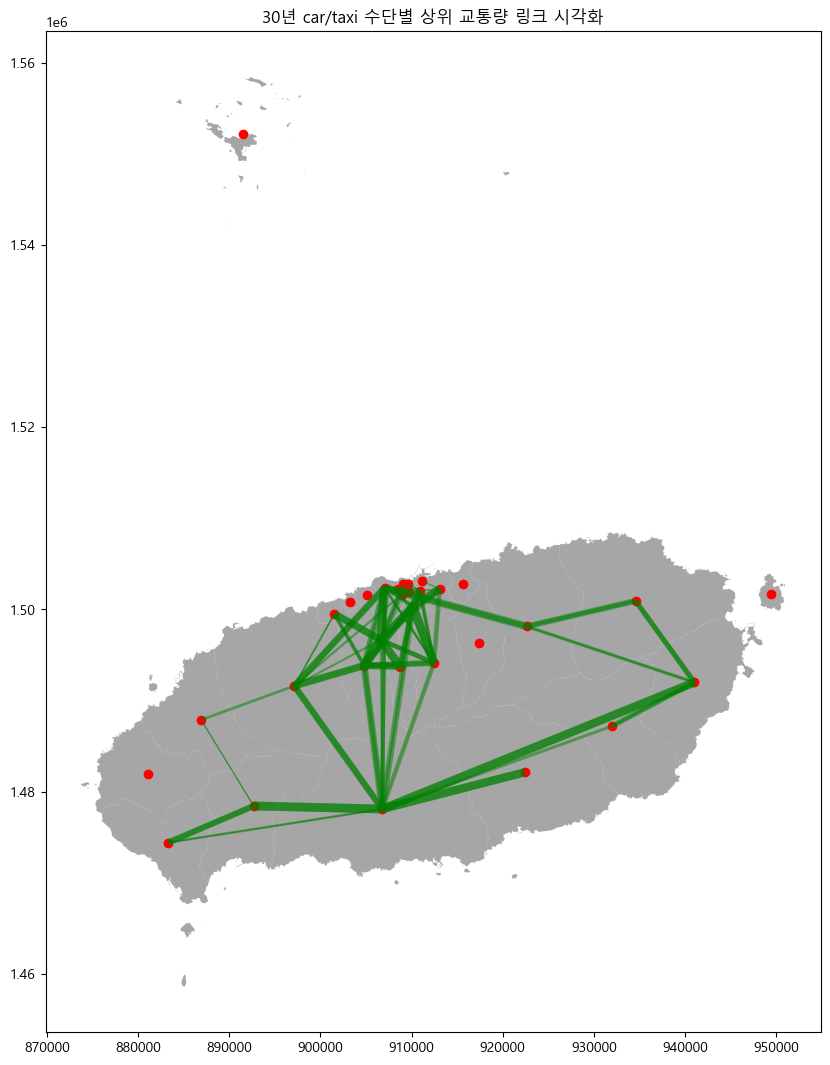

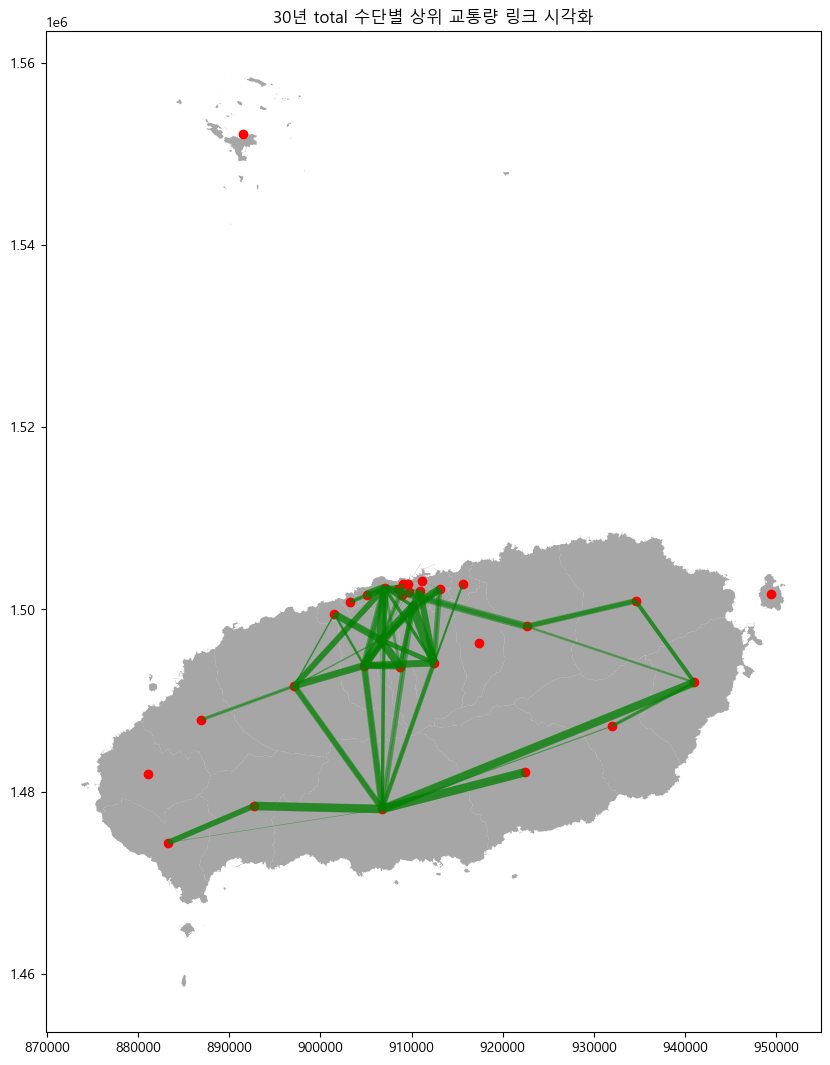

In [35]:
# 30년 수단별 상위 교통량 링크
od30_bus = top_traffic_link(od_30_gdf, 'bus', '30년')
od30_cartaxi = top_traffic_link(od_30_gdf, 'car/taxi', '30년')
od30_total = top_traffic_link(od_30_gdf, 'total', '30년')

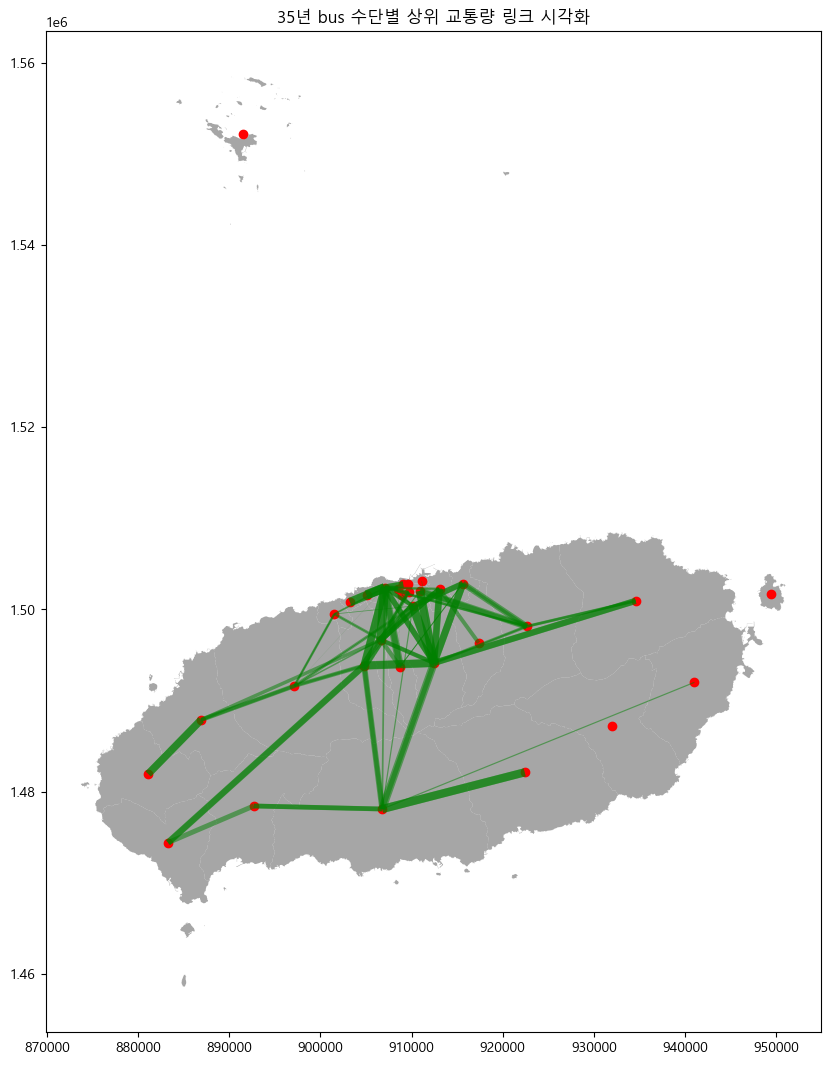

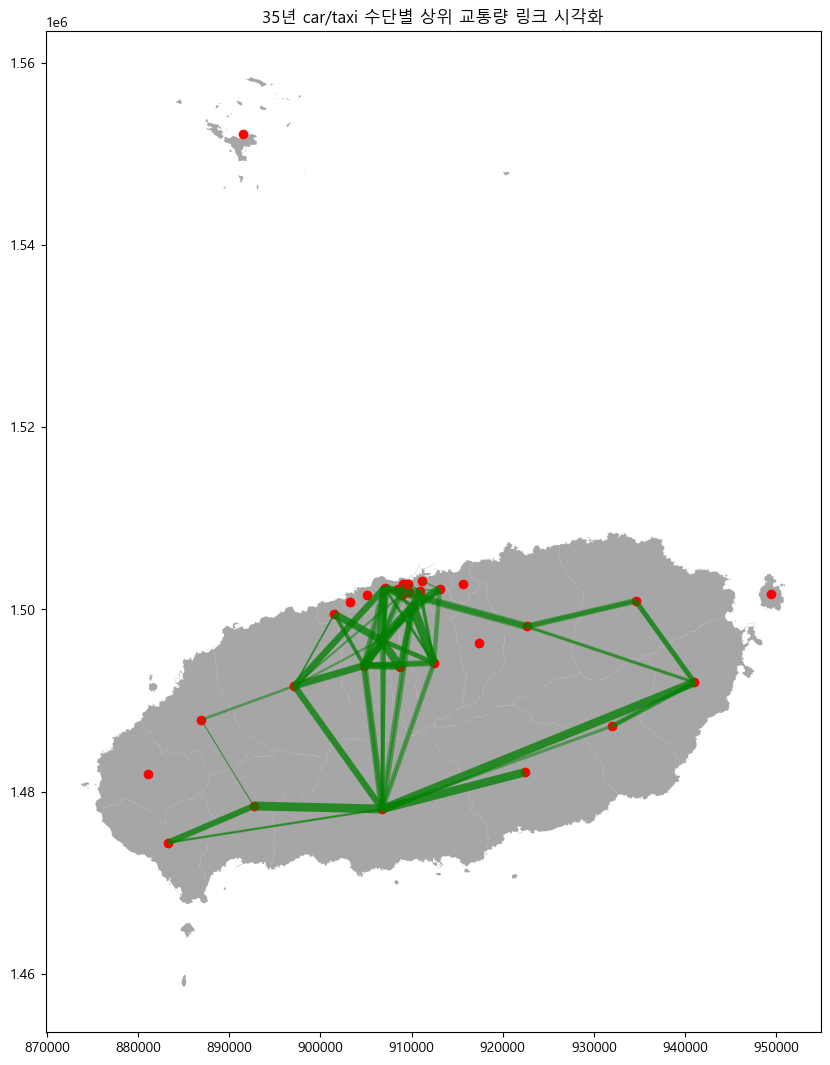

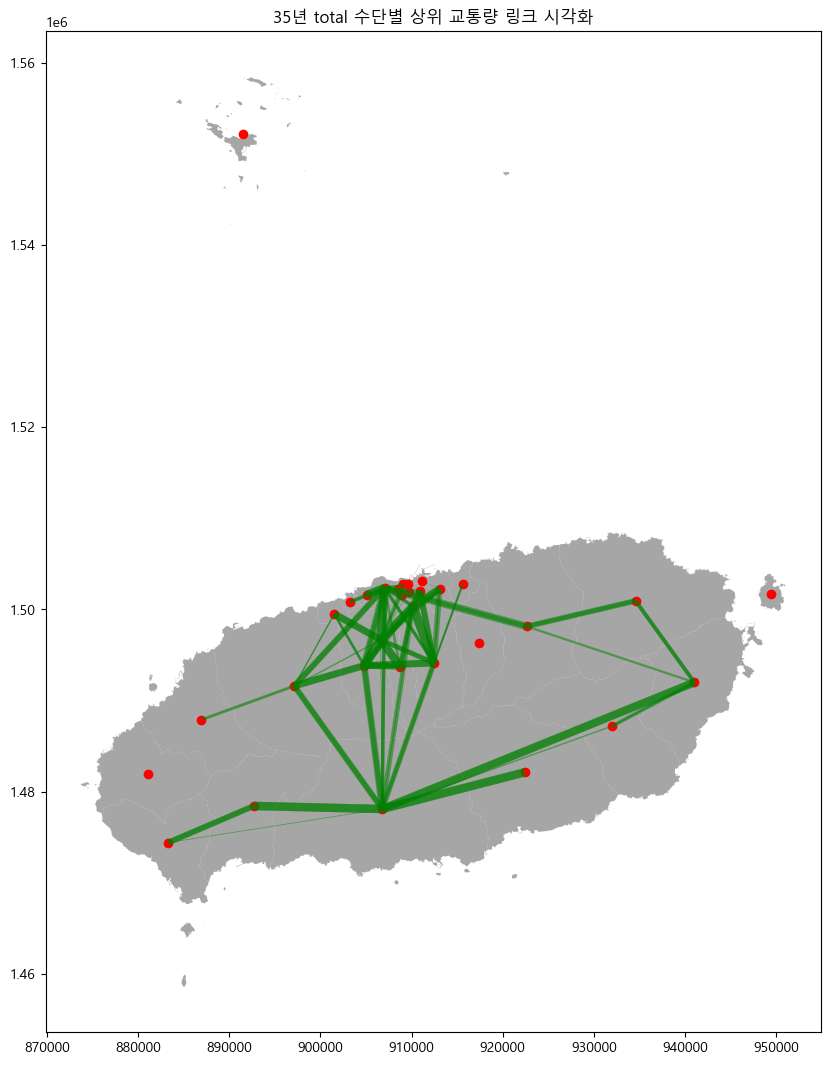

In [36]:
# 30년 수단별 상위 교통량 링크
od35_bus = top_traffic_link(od_35_gdf, 'bus', '35년')
od35_cartaxi = top_traffic_link(od_35_gdf, 'car/taxi', '35년')
od35_total = top_traffic_link(od_35_gdf, 'total', '35년')